In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%load_ext cython

In [4]:
def naive_parallel_filter(x,result,coeff,history):
    nsamp = x.shape[1]
    nstreams = x.shape[0]
    ntaps = coeff.shape[0]
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
                
        for iresult in range(ntaps,nsamp):
            for icoeff in range(ntaps):
                result[istream,iresult] += coeff[icoeff]*x[istream,iresult-ntaps+icoeff]


In [5]:
ntaps = 32
x = np.zeros((16,2**10),dtype=np.complex64)
coeff = np.ones((ntaps,),dtype=np.float32)
history = x[:,:ntaps].copy()
result = np.zeros_like(x)


In [6]:
%timeit naive_parallel_filter(x,result,coeff,history)

1 loop, best of 3: 1.63 s per loop


In [21]:
%%cython --cplus

def cython1_parallel_filter(x,result,coeff,history):
    nsamp = x.shape[1]
    nstreams = x.shape[0]
    ntaps = coeff.shape[0]
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
                
        for iresult in range(ntaps,nsamp):
            for icoeff in range(ntaps):
                result[istream,iresult] += coeff[icoeff]*x[istream,iresult-ntaps+icoeff]


In [22]:
%timeit cython1_parallel_filter(x,result,coeff,history)

1 loop, best of 3: 1.67 s per loop


In [23]:
%%cython --cplus

cimport numpy as np
def cython2_parallel_filter(np.ndarray x, np.ndarray result,np.ndarray coeff,np.ndarray history):
    cdef int nsamp = x.shape[1]
    cdef int nstreams = x.shape[0]
    cdef int ntaps = coeff.shape[0]
    cdef int icoeff = 0
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
                
        for iresult in range(ntaps,nsamp):
            for icoeff in range(ntaps):
                result[istream,iresult] += coeff[icoeff]*x[istream,iresult-ntaps+icoeff]


In [24]:
%timeit cython2_parallel_filter(x,result,coeff,history)

1 loop, best of 3: 1.68 s per loop


In [17]:
%%cython --cplus

cimport numpy as np
def cython3_parallel_filter(np.ndarray[np.complex64_t, ndim=2] x, np.ndarray[np.complex64_t, ndim=2] result,np.ndarray[np.float32_t, ndim=1] coeff,np.ndarray[np.complex64_t, ndim=2] history):
    cdef int nsamp = x.shape[1]
    cdef int nstreams = x.shape[0]
    cdef int ntaps = coeff.shape[0]
    cdef int icoeff = 0
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
                
        for iresult in range(ntaps,nsamp):
            for icoeff in range(ntaps):
                result[istream,iresult] += coeff[icoeff]*x[istream,iresult-ntaps+icoeff]


In [18]:
%timeit cython3_parallel_filter(x,result,coeff,history)

1 loop, best of 3: 3.13 s per loop


In [4]:
%%cython --cplus --annotate

cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def cython4_parallel_filter(np.ndarray[np.complex64_t, ndim=2] x, np.ndarray[np.complex64_t, ndim=2] result,np.ndarray[np.float32_t, ndim=1] coeff,np.ndarray[np.complex64_t, ndim=2] history):
    cdef int nsamp = x.shape[1]
    cdef int nstreams = x.shape[0]
    cdef int ntaps = coeff.shape[0]
    cdef int icoeff = 0
    cdef int iresult =0
    cdef int istream =0
    cdef int itap=0
    cdef int ihistory=0
    cdef int isamp =0
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
                
        for iresult in range(ntaps,nsamp):
            for icoeff in range(ntaps):
                result[istream,iresult] += coeff[icoeff]*x[istream,iresult-ntaps+icoeff]


In [34]:
%timeit cython4_parallel_filter(x,result,coeff,history)

100 loops, best of 3: 11.1 ms per loop


In [73]:
ntaps = 128
x = np.zeros((512,2**12),dtype=np.complex64)
coeff = np.ones((ntaps,),dtype=np.float32)
history = x[:,:ntaps].copy()
result = np.zeros_like(x)
H = np.fft.fft(coeff,n=x.shape[1]).astype('complex64')

In [172]:
%timeit np.moveaxis(x.view(np.float32).reshape((512,2**12,2)),2,1).copy()

100 loops, best of 3: 14.2 ms per loop


In [177]:
%timeit np.transpose(x.view(np.float32).reshape((512,2**12,2)),(0,2,1)).copy()

100 loops, best of 3: 13.9 ms per loop


In [173]:
%timeit x.copy()

100 loops, best of 3: 6.64 ms per loop


In [176]:
(2**9*2**12)/16e6

0.131072

In [175]:
((2**9*2**12)/14.3e-3)/1e6

146.653986013986

In [174]:
np.moveaxis(x.view(np.float32).reshape((512,2**12,2)),2,1).copy().flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [78]:
def fftconv(x,H,fftlib,**kwargs):
    return fftlib.ifft(H*fftlib.fft(x,axis=1,**kwargs),axis=1,**kwargs)

In [53]:
%timeit np.fft.fft(x,axis=1)

10 loops, best of 3: 115 ms per loop


In [45]:
import scipy.fftpack as sfft

In [64]:
%timeit sfft.fft(x,axis=1)

10 loops, best of 3: 32.8 ms per loop


In [47]:
import pyfftw

In [59]:
pyfftw.interfaces.cache.enable()

In [62]:
pyfftw.interfaces.cache.set_keepalive_time(86400)

In [65]:
%timeit pyfftw.interfaces.scipy_fftpack.fft(x,axis=1)

100 loops, best of 3: 18.3 ms per loop


In [79]:
%timeit fftconv(x,H,fftlib=pyfftw.interfaces.scipy_fftpack)

10 loops, best of 3: 50.6 ms per loop


In [82]:
%timeit fftconv(x,H,fftlib=pyfftw.interfaces.scipy_fftpack,threads=2)

10 loops, best of 3: 38.4 ms per loop


In [76]:
%timeit fftconv(x,H,fftlib=np.fft)

1 loop, best of 3: 292 ms per loop


In [77]:
%timeit fftconv(x,H,fftlib=sfft)

10 loops, best of 3: 81.2 ms per loop


In [83]:
(2**21./30e-3)/1e6

69.90506666666667

In [6]:
%timeit cython4_parallel_filter(x,result,coeff,history)

1 loop, best of 3: 359 ms per loop


In [7]:
355/11.

32.27272727272727

In [ ]:
(2**29/.355)/1e6

In [1]:
1

1

In [37]:
%%cython --cplus --annotate

cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def real_parallel_filter(np.ndarray[np.float32_t, ndim=2] x, np.ndarray[np.float32_t, ndim=2] result,np.ndarray[np.float32_t, ndim=1] coeff,np.ndarray[np.float32_t, ndim=2] history):
    cdef int nsamp = x.shape[1]
    cdef int nstreams = x.shape[0]
    cdef int ntaps = coeff.shape[0]
    cdef int icoeff = 0
    cdef int iresult =0
    cdef int istream =0
    cdef int itap=0
    cdef int ihistory=0
    cdef int isamp =0
    cdef int idx=0
    for istream in range(nstreams):
        for itap in range(ntaps):
            icoeff = 0
            for ihistory in range(itap,ntaps):
                result[istream,itap] += coeff[icoeff]*history[istream,ihistory]
                icoeff += 1
            for isamp in range(0,itap):
                result[istream,itap] += coeff[icoeff]*x[istream,isamp]
                icoeff += 1
        for iresult in range(ntaps,nsamp):
            idx = iresult-ntaps
            for icoeff in range(ntaps):
                
                result[istream,iresult] += coeff[icoeff]*x[istream,idx]
                idx += 1


In [38]:
ntaps = 32
x = np.zeros((1024,2**10),dtype=np.float32)
coeff = np.ones((ntaps,),dtype=np.float32)
history = x[:,:ntaps].copy()
result = np.zeros_like(x)

In [41]:
%timeit real_parallel_filter(x,result,coeff,history)

10 loops, best of 3: 154 ms per loop


In [34]:
(2**20./151e-3)/1e6

6.944211920529801

In [22]:
(2**25./.152)/1e6

220.75284210526317

In [85]:
import scipy.signal as signal

In [86]:
signal.freqz?

In [121]:
signal.butter?

In [ ]:
signal.firwin()

In [153]:
w = np.linspace(0,10/128.,1024)
w,h = signal.freqz(np.ones(128,)/2**7.,1,worN=w)
w,h_kaiser = signal.freqz(signal.kaiser(128*8,64),1,worN=w)



(-80, 5)

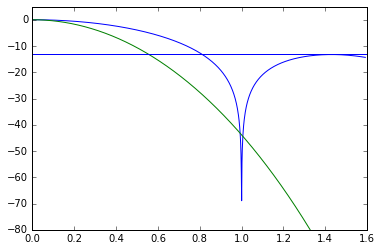

In [157]:
plot(128*w/(2*np.pi),20*np.log10(np.abs(h)))
plot(128*w/(2*np.pi),20*np.log10(np.abs(h_kaiser)/np.abs(h_kaiser).max()))
#axvline(1/128.)
axhline(-13)
ylim(-80,5)

In [135]:
2*np.pi/128.

0.04908738521234052